# Análisis de la vida académica de la Facultad de Ciencias
## Indicadores de Profesores de Asignatura

### Carga de librerías para el análisis 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import matplotlib.pyplot as plt

### Cargar bases de datos que utilizaremos

In [2]:
df_courses=pd.read_csv('../Data/courses.csv', dtype = {'ID': str,'CourseName': str}).set_index('ID')

df_groups=pd.read_csv('../Data/groups.csv', dtype = {'GroupYSID': str,'Quota': int,'Signed':int}).set_index('GroupYSID')

df_profs=pd.read_csv('../Data/profs-anon.csv', dtype = {'ID': int, 'Name':str, 'Appointment':str,'SimpAppointment': 'category'}).set_index('ID')

df_teaching=pd.read_csv('../Data/teaching.csv', dtype = {'ProfID': int,'GroupYSID': str,'ProfType':'category', 'Days': str, 'Hours': str})

df_plans=pd.read_csv('../Data/plans_courses.csv', dtype={'CourseID':int,'PlanID':"int64",'CourseType':'category'})

df_plan_names=pd.read_csv('../Data/plans.csv').set_index('ID')

# Hay algunas materias homólogas que no queremos que estén
df_homologas=pd.read_csv('../Data/homologas.csv')
df_homologas['old_name_code']=df_homologas['old_name_code'].apply(lambda x: '{:0>4d}'.format(x))
df_homologas['new_name_code']=df_homologas['new_name_code'].apply(lambda x: '{:0>4d}'.format(x))

In [3]:
for df in [df_courses, df_groups, df_profs, df_teaching, df_plans]:
    display(df.sample(3))

CourseName
ID                                                     
0377                       Comercio de la Biodiversidad
2004                    Temas Selectos de Astrofísica I
0351  Introducción a las Funciones Recursivas y Comp...

Quota  Signed
GroupYSID                      
2007-2-0606-7019      0      22
2017-1-1208-9012      0      19
2001-1-0249-4057     27      29

Appointment SimpAppointment
ID                                                       
60657              Profesor de Asignatura              PA
62629  Ayudante de Profesor de Asignatura            Ayud
52745  Ayudante de Profesor de Asignatura            Ayud

ProfID         GroupYSID  ProfType      Days    Hours
52029    34171  2016-2-0840-4370  Profesor  lu mi vi  11 a 12
30959    33314  2001-1-0005-4090  Profesor  lu mi vi   9 a 10
100477   56948  2013-2-0245-4073  Ayudante     ma ju   9 a 10

CourseID  PlanID   CourseType
1030      1012     201     Optativa
261        610     106  Obligatoria
801       1531     134  Obligatoria

### Agregar funciones útiles

In [4]:
def get_course_name(courseid):
    try:
        if type(courseid)==int:
            courseid='{:0>4d}'.format(courseid)
        if type(courseid)==str:
            return(df_courses.loc[courseid]['CourseName'])
    except:
        return "Not found"
    
def es_asignatura(text):
    if text=='PA':
        return(1)
    else:
        return(0)

### Agregar columnas útiles

Para `df_teaching`

In [5]:
df_teaching['CourseID']=df_teaching['GroupYSID'].apply(lambda x: x.split('-')[-2])
df_teaching['Semester']=df_teaching['GroupYSID'].apply(lambda x:x[:6])
df_teaching['CourseName']=df_teaching['CourseID'].apply(get_course_name)
display(df_teaching['CourseID'].head())
display(df_teaching['Semester'].head())
display(df_teaching['CourseName'].head())

0    2017
1    0307
2    0827
3    0302
4    0302
Name: CourseID, dtype: object

0    2016-1
1    2006-2
2    2008-1
3    2007-1
4    2007-2
Name: Semester, dtype: object

0                          Meteorología
1    Máquinas Digitales con Laboratorio
2        Dinámica de Medios Deformables
3                  Fenómenos Colectivos
4                  Fenómenos Colectivos
Name: CourseName, dtype: object

Para `df_profs`

In [6]:
df_profs['Asignatura']=df_profs['SimpAppointment'].apply(es_asignatura)

### Tipos de semestre

In [7]:
sem_1=['{}-1'.format(j) for j in range(2001,2022)]
sem_2=['{}-2'.format(j) for j in range(2001,2022)]
sem_3=['{}-3'.format(j) for j in range(2001,2022)]
sem_4=['{}-4'.format(j) for j in range(2001,2022)]
sem_regular=sorted(sem_1+sem_2)
sem_inter=sorted(sem_3+sem_4)
sem_1_recent=['{}-1'.format(j) for j in range(2017,2022)]
sem_2_recent=['{}-2'.format(j) for j in range(2017,2022)]
sem_3_recent=['{}-3'.format(j) for j in range(2017,2022)]
sem_4_recent=['{}-4'.format(j) for j in range(2017,2022)]
sem_regular_recent=sorted(sem_1_recent+sem_2_recent)
sem_inter_recent=sorted(sem_3_recent+sem_3_recent)

## Join de la información

In [8]:
df_teaching_join=df_teaching.join(df_groups,on='GroupYSID').join(df_profs, on='ProfID')
df_teaching_join['Asignatura']=df_teaching_join['SimpAppointment'].apply(es_asignatura)
df_teaching_join.head()

# Quitamos las materias homólogas. Dejamos sólo con el nombre reciente.
print(df_teaching_join.shape)
df_teaching_join=df_teaching_join[~df_teaching_join['CourseID'].isin(df_homologas['old_name_code'])]
print(df_teaching_join.shape)

(146660, 13)
(140357, 13)


In [9]:
df_teaching_join.sample(5)

ProfID         GroupYSID     ProfType   Days    Hours CourseID  \
140660   82775  2021-2-1800-5427     Profesor    NaN      NaN     1800   
69878    41192  2004-2-0162-4089     Ayudante  ma ju   9 a 10     0162   
24689    33038  2013-1-1404-5249     Profesor     vi  11 a 14     1404   
144749   92386  2017-2-1819-1079     Profesor  ma ju  14 a 16     1819   
120139   65030  2020-1-1102-5028  Laboratorio     lu  18 a 21     1102   

       Semester                                         CourseName  Quota  \
140660   2021-2                                     Taller Nivel 4      0   
69878    2004-2                         Ecuaciones Diferenciales I      0   
24689    2013-1                                         Genética I     25   
144749   2017-2  Políticas y Normatividad en el Manejo de los S...     31   
120139   2020-1                                             Física     25   

        Signed                         Appointment SimpAppointment  Asignatura  
140660       4    Investigador de Carrera Asociado             Inv         0.0  
69878       57  Ayudante de Profesor de Asignatura            Ayud         0.0  
24689       25        Profesora de Carrera Titular             PTC         0.0  
144749      31             Profesora de Asignatura              PA         1.0  
120139      24             Profesora de Asignatura              PA         1.0

## Histórico asignatura vs. no asignatura

En esta parte estudiamos de manera histórica cuántos grupos han sido atendidos por profesores de asignatura y cuántos por profesores de carrera. De momento nos interesa quién dirige el grupo, de modo que filtramos nuestra información por `ProfType`.

In [10]:
df_teaching_join_prof=df_teaching_join[(df_teaching_join['ProfType']=='Profesor')&(df_teaching_join['Semester'].isin(sem_regular))]
df_teaching_join_prof.sample(5)

ProfID         GroupYSID  ProfType      Days         Hours CourseID  \
34199    33428  2014-2-1506-9090  Profesor  lu mi vi       10 a 11     1506   
116504   63776  2019-2-1404-5221  Profesor        mi  7:30 a 10:30     1404   
25520    33077  2007-2-1405-5174  Profesor        ma       18 a 21     1405   
71967    41297  2018-2-0435-1180  Profesor        mi       15 a 18     0435   
96589    55558  2016-1-0244-4066  Profesor  lu mi vi       17 a 18     0244   

       Semester                    CourseName  Quota  Signed  \
34199    2014-2  Investigación de Operaciones      0      38   
116504   2019-2                    Genética I     25      22   
25520    2007-2                 Paleobiología     25      25   
71967    2018-2                    Limnología     15       5   
96589    2016-1         Geometría Analítica I      0      52   

                          Appointment SimpAppointment  Asignatura  
34199   Profesora de Carrera Asociado             PTC         0.0  
116504        Profesora de Asignatura              PA         1.0  
25520          Profesor de Asignatura              PA         1.0  
71967     Profesor de Carrera Titular             PTC         0.0  
96589         Profesora de Asignatura              PA         1.0

Para esta parte sólo nos interesan algunas de las columnas del dataframe.

In [11]:
df_aux=df_teaching_join_prof[['GroupYSID','Asignatura','Semester','Signed']]
df_aux=df_aux.groupby(['GroupYSID']).first().reset_index()
df_aux.head()

GroupYSID  Asignatura Semester  Signed
0  2001-1-0001-4114         0.0   2001-1       6
1  2001-1-0001-4115         0.0   2001-1      24
2  2001-1-0001-4116         1.0   2001-1      12
3  2001-1-0001-4117         0.0   2001-1      14
4  2001-1-0001-4118         0.0   2001-1      14

Agrupamos y agregamos para ver cuántos grupos y cuántos estudiantes han antendido profesores de asignatura y profesores de carrera.

In [12]:
df_aux=df_aux.groupby(['Asignatura','Semester']).agg({'GroupYSID':'count','Signed':'sum'})
df_aux=df_aux.unstack(0)
df_aux.head()

GroupYSID      Signed      
Asignatura       0.0  1.0    0.0   1.0
Semester                              
2001-1           438  405   8250  8753
2001-2           403  359   7313  7327
2002-1           438  373   9200  8761
2002-2           455  338   8098  6457
2003-1           496  384   9164  8228

Ahora sí, hacemos las figuras

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


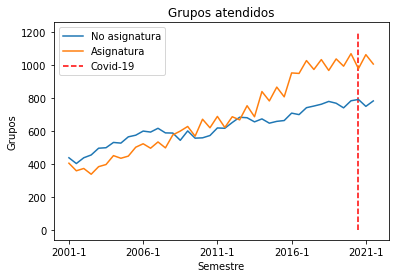

In [13]:
ax = df_aux['GroupYSID'][0].plot(label='No asignatura',title='Grupos atendidos')
df_aux['GroupYSID'][1].plot(ax=ax,label='Asignatura',xlabel='Semestre',ylabel='Grupos')
ax.vlines(39,0,1200,label='Covid-19',color='red',linestyles='dashed')
ax.legend()
plt.savefig('../Figuras/grupos.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


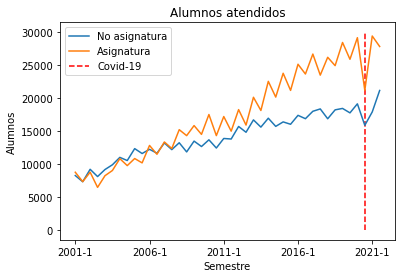

In [14]:
ax = df_aux['Signed'][0].plot(label='No asignatura',title='Alumnos atendidos')
df_aux['Signed'][1].plot(ax=ax,label='Asignatura',xlabel='Semestre',ylabel='Alumnos')
ax.vlines(39,0,30000,label='Covid-19',color='red',linestyles='dashed')
ax.legend()
plt.savefig('../Figuras/alumnos.eps', format='eps')
plt.show()

## Histórico por curso y menor cantidad de asignatura recientes ($\alpha$)

Hacemos un análisis similar, pero restringido a algún curso y sólo para semestres recientes. Esto es sencillo, simplemente hay que elegir el filtro correspondiente. Se puede elegir la materia cambiando el valor de la variable `course_id`.

In [15]:
course_id='0091'
course_name=get_course_name(course_id)
print(course_id,course_name)

0091 Cálculo Diferencial e Integral I


In [16]:
filter_prof=(df_teaching_join['ProfType']=='Profesor')
filter_time=(df_teaching_join['Semester'].isin(sem_regular_recent))
filter_course=(df_teaching_join['CourseID']==course_id)
df_teaching_aux=df_teaching_join[filter_prof&filter_time&filter_course]
df_aux=df_teaching_aux[['GroupYSID','Asignatura','Semester','Signed']]
df_aux=df_aux.groupby(['GroupYSID']).first().reset_index()
df_aux=df_aux.groupby(['Asignatura','Semester']).agg({'GroupYSID':'count','Signed':'sum'})
df_aux=df_aux.unstack(0)
df_aux.head()

GroupYSID       Signed        
Asignatura       0.0   1.0    0.0     1.0
Semester                                 
2017-1          12.0  16.0  875.0   900.0
2017-2           NaN  12.0    NaN   658.0
2018-1           9.0  18.0  549.0  1125.0
2018-2           2.0   9.0  114.0   471.0
2019-1           9.0  23.0  584.0  1253.0

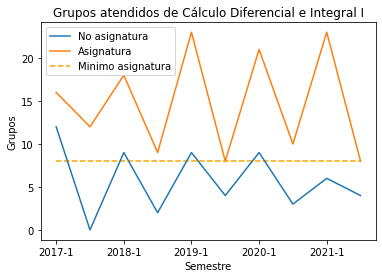

In [17]:
ax = df_aux['GroupYSID'][0].fillna(0).plot(label='No asignatura',title='Grupos atendidos de {}'.format(course_name),xlabel='Semestre',ylabel='Grupos')
df_aux['GroupYSID'][1].fillna(0).plot(ax=ax,label='Asignatura',xlabel='Semestre',ylabel='Grupos')
plt.hlines(df_aux['GroupYSID'][1].fillna(0).min(),0,9,label='Minimo asignatura',linestyles='dashed',color='orange')
ax.legend()
# plt.savefig('../Figuras/calculo_grupos.eps', format='eps')
plt.show()

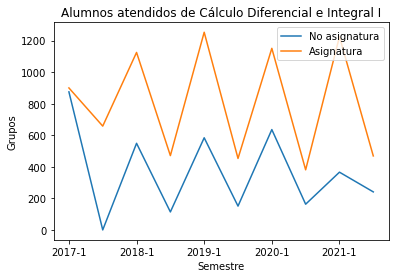

In [18]:
ax = df_aux['Signed'][0].fillna(0).plot(label='No asignatura',title='Alumnos atendidos de {}'.format(course_name),xlabel='Semestre',ylabel='Grupos')
df_aux['Signed'][1].fillna(0).plot(ax=ax,label='Asignatura',xlabel='Semestre',ylabel='Grupos')
ax.legend()
# plt.savefig('../Figuras/calculo_alumnos.eps', format='eps')
plt.show()

En general, podemos calcular el valor de $\alpha$ para una materia como sigue:

In [19]:
filter_prof=(df_teaching_join['ProfType']=='Profesor')
filter_time=(df_teaching_join['Semester'].isin(sem_regular_recent))
df_teaching_aux=df_teaching_join[filter_prof&filter_time]

def alpha(course_id):
    df_teaching_aux_loc=df_teaching_aux[df_teaching_aux['CourseID']==course_id]
    df_aux=df_teaching_aux_loc[['GroupYSID','Asignatura','Semester']]
    df_aux=df_aux.groupby(['GroupYSID']).first().reset_index()
    df_aux=df_aux.groupby(['Asignatura','Semester']).agg({'GroupYSID':'count'})
    df_aux=df_aux.unstack(0)
    try:
        return df_aux['GroupYSID'][1].fillna(0).min()
    except Exception as exception:
        return(type(exception).__name__+"")

In [20]:
alpha("0091")

8.0

## Distribución de impartición ($\beta$)

Para cada profesor de asignatura,¿cuántas veces ha dado un curso? Ya que tenemos eso, ¿cómo se ve la distribución por curso? Una vez más, lo siguiente se puede hacer por asignatura, usando el código de materia en XFC.

In [21]:
course_id='0091'
course_name=get_course_name(course_id)
print(course_id,course_name)

0091 Cálculo Diferencial e Integral I


In [22]:
filter_prof=(df_teaching_join['ProfType']=='Profesor')
filter_time=(df_teaching_join['Semester'].isin(sem_regular_recent))
filter_course=(df_teaching_join['CourseID']==course_id)
filter_asig=(df_teaching_join['Asignatura']==1)

df_teaching_aux=df_teaching_join[filter_prof&filter_time&filter_course&filter_asig]
df_aux=df_teaching_aux[['ProfID','Semester']]
df_aux=df_aux.groupby(['ProfID']).count()
df_aux.head()

Semester
ProfID          
1987           2
4102           4
6140           2
12138          1
17629          1

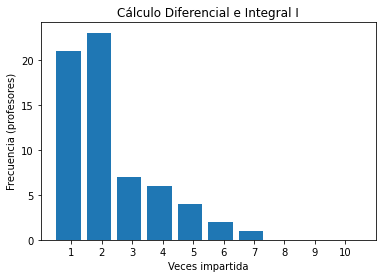

In [23]:
ax=df_aux.plot(kind='hist',bins=np.arange(1,12,1),xticks=np.arange(1,11,1), align='left',width=0.8)
ax.set_xlabel('Veces impartida')
ax.set_ylabel('Frecuencia (profesores)')
ax.set_title('{}'.format(course_name))
ax.get_legend().remove()
plt.savefig('../Figuras/dist_calculo.eps', format='eps')
plt.show()

Para calcular el valor de $\beta$ para una materia, lo que se hace es contar el número de profesores de asignatura que en los últimos 10 semestres han impartido la materia al menos 6 veces.

In [24]:
filter_prof=(df_teaching_join['ProfType']=='Profesor')
filter_time=(df_teaching_join['Semester'].isin(sem_regular_recent))
filter_asig=(df_teaching_join['Asignatura']==1)
df_teaching_aux=df_teaching_join[filter_prof&filter_time&filter_asig]

def beta(course_id):
    filter_course=(df_teaching_aux['CourseID']==course_id)
    df_teaching_aux_loc=df_teaching_aux[filter_course]
    df_aux=df_teaching_aux_loc[['ProfID','Semester']]
    df_aux=df_aux.groupby(['ProfID']).count()
    return(len(df_aux[df_aux['Semester']>=6]))

In [25]:
beta('0091')

3

## Indicadores para materias obligatorias

In [26]:
df_plan_names

PlanName
ID                             
101                    Actuaría
104  Ciencias de la Computación
106                      Física
122                 Matemáticas
127       Ciencias de la Tierra
134            Física Biomédica
136       Matemáticas Aplicadas
201                    Biología

Veamos los indicadores $\alpha$ y $\beta$ para cada materia obligatoria. Se puede cambiar el plan cambiando la variable `plan_id` aquí abajo.

In [27]:
plan_id=122

In [28]:
obli_plan=df_plans[(df_plans['PlanID']==plan_id)&(df_plans['CourseType']=='Obligatoria')].copy()
obli_plan["CourseName"]=obli_plan['CourseID'].apply(lambda x: get_course_name(x))
obli_plan["Alpha"]=obli_plan['CourseID'].apply(lambda x:alpha('{:0>4d}'.format(x)))
obli_plan["Beta"]=obli_plan['CourseID'].apply(lambda x:beta('{:0>4d}'.format(x)))
obli_plan

CourseID  PlanID   CourseType                          CourseName  Alpha  \
466         7     122  Obligatoria                  Álgebra Superior I      5   
467        91     122  Obligatoria    Cálculo Diferencial e Integral I      8   
468       244     122  Obligatoria               Geometría Analítica I      8   
469       249     122  Obligatoria                 Geometría Moderna I      2   
470         8     122  Obligatoria                 Álgebra Superior II      7   
471        92     122  Obligatoria   Cálculo Diferencial e Integral II      7   
472       245     122  Obligatoria              Geometría Analítica II      5   
473         5     122  Obligatoria                    Álgebra Lineal I      7   
474        93     122  Obligatoria  Cálculo Diferencial e Integral III      7   
475         6     122  Obligatoria                   Álgebra Lineal II      2   
476        94     122  Obligatoria   Cálculo Diferencial e Integral IV      6   
477       162     122  Obligatoria          Ecuaciones Diferenciales I      7   
478         1     122  Obligatoria                   Álgebra Moderna I      2   
479         9     122  Obligatoria               Análisis Matemático I      3   
480       840     122  Obligatoria                 Variable Compleja I      1   
481        10     122  Obligatoria              Análisis Matemático II      2   

     Beta  
466     0  
467     3  
468     2  
469     2  
470     0  
471     0  
472     1  
473     1  
474     0  
475     0  
476     2  
477     3  
478     1  
479     0  
480     0  
481     0

¿Cómo se ven estos valores?

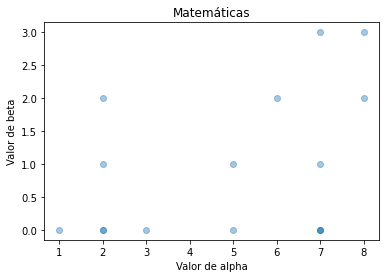

In [29]:
plt.scatter(obli_plan['Alpha'],obli_plan['Beta'],alpha=0.4)
plt.xlabel('Valor de alpha')
plt.ylabel('Valor de beta')
plt.title("{}".format(df_plan_names.loc[plan_id]['PlanName']))
plt.show()

¿Cómo se ve para todas las obligatorias?

In [41]:
obli=df_plans[(df_plans['CourseType']=='Obligatoria')].groupby(['CourseID']).first().reset_index()
obli["CourseName"]=obli['CourseID'].apply(lambda x: get_course_name(x))
obli["Alpha"]=obli['CourseID'].apply(lambda x:alpha('{:0>4d}'.format(x)))
obli["Beta"]=obli['CourseID'].apply(lambda x:beta('{:0>4d}'.format(x)))

In [43]:
# Hay que quitar algunas materias que producen KeyError. También quitamos los talleres de biología pues tienen un comportamiento muy distinto.
obli=obli[(obli.Alpha!='KeyError')&(~obli.CourseID.isin(['1503','1603','1700','1800']))]

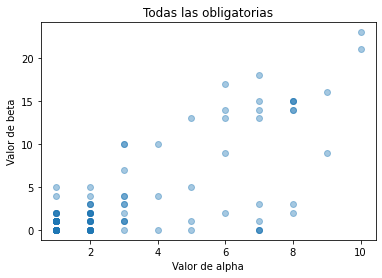

In [44]:
plt.scatter(obli['Alpha'],obli['Beta'],alpha=0.4)
plt.xlabel('Valor de alpha')
plt.ylabel('Valor de beta')
plt.title("Todas las obligatorias")
plt.show()